# imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os 

from scipy.misc import imresize
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pickle

import sys
sys.path.append('utils')

import Metrics
from Binarizer import *
from Encoder import Encoder
from datasetGenerator import DCASE2018

from evaluation_measures import event_based_evaluation
from dcase_util.containers import MetaDataContainer # dependency: dcase-util 0.2.4



In [5]:
import keras 

from keras.models import model_from_json, load_model

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Lambda, \
    Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, TimeDistributed, \
    GRU, Reshape, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout2D, \
    Concatenate, Multiply
from keras import backend as K

import tensorflow as tf

In [6]:
K.set_image_data_format("channels_last")
K.image_data_format()

'channels_last'

In [7]:
K.clear_session()

In [8]:
# set seeds
from numpy.random import seed
seed(123) 

from tensorflow import set_random_seed
set_random_seed(1234)

# load data

In [9]:
metaRoot = '/baie/corpus/DCASE2018/task4/metadata'
featRoot = '/baie/corpus/DCASE2018/task4/FEATURES'
feat = ["mel"]
# feat = ["mel", "stack"]
normalizer=None
dataset = DCASE2018(
    featureRoot=featRoot,
    metaRoot=metaRoot,
    features=feat,
    validationPercent=0.2,
    normalizer=normalizer
)


mel


In [10]:
dataset.trainingDataset['mel']['input'].shape, dataset.validationDataset['mel']['input'].shape

((1763, 64, 431, 1), (438, 64, 431, 1))

In [9]:
for k,v in DCASE2018.class_correspondance.items():
    print(k,v)

Running_water 9
Blender 8
Frying 6
Vacuum_cleaner 4
Speech 1
Alarm_bell_ringing 0
Dog 2
Dishes 5
Electric_shaver_toothbrush 7
Cat 3


In [11]:
### load saved subsets for reproductibility (always the same train/dev subsets)
loaded = np.load('../thomas_subsets/subsets.npz')
x_train = loaded['x_train']
x_val = loaded['x_val']
y_train = loaded['y_train']
y_val = loaded['y_val']

x_train.shape, x_val.shape, y_train.shape, y_val.shape


((1763, 64, 431, 1), (438, 64, 431, 1), (1763, 10), (438, 10))

In [12]:
# Load the test data, create the test dataset
# load the file list

featTestPath = featRoot + '/test/mel' 
featTestList = os.listdir(featTestPath)

# load the meta data ----
ref_event_list = MetaDataContainer()   
ref_event_list.load(filename=dataset.meta_test)

dico_y_test = {} # keys: .wav.npy files, values: y label
for el in ref_event_list:
    fname=el['filename']
    label=el['event_label']
    # num_label=DCASE2018.class_correspondance[el['event_label']]
    if fname + '.npy' in  dico_y_test:
        if label not in dico_y_test[fname + '.npy']: 
            dico_y_test[fname + '.npy'].append(label)
    else:
        dico_y_test[fname + '.npy'] = [label]

# metaPath = metaRoot + "/test.csv"
# with open(metaPath, "r") as metaFile:
#     metadata = metaFile.read().splitlines()[1:]
    
# metadata = [i.split("\t") for i in metadata]

# load the features and create y_test
featTest = []
y_test_lists = []

y_test = np.zeros((len(featTestList), dataset.nbClass))

for ind, file in enumerate(featTestList):
    path = os.path.join(featTestPath, file)
    feature = np.load(path)
       
    # preprocessing
    feature = np.expand_dims(feature, axis=-1)
    featTest.append(feature)
    
    # y labels
    y_test_lists.append(dico_y_test[file])
    for ev in dico_y_test[file]:
        y_test[ind, DCASE2018.class_correspondance[ev]] = 1
        
featTest = np.array(featTest)

featTest.shape, ref_event_list[:3], featTestList[:1], dico_y_test['Y0kAaPH2wrvM_140.000_150.000.wav.npy'], y_test_lists[:5], y_test[:5]

((279, 64, 431, 1),
 [{'event_label': 'Vacuum_cleaner',
   'filename': 'Y00pbt6aJV8Y_350.000_360.000.wav',
   'offset': 9.971,
   'onset': 0.0},
  {'event_label': 'Vacuum_cleaner',
   'filename': 'Y00pK0GMmE9s_70.000_80.000.wav',
   'offset': 10.0,
   'onset': 0.0},
  {'event_label': 'Frying',
   'filename': 'Y02sD1KJeoGA_50.000_60.000.wav',
   'offset': 10.0,
   'onset': 0.0}],
 ['Y0UN02RkbG_U_7.000_17.000.wav.npy'],
 ['Vacuum_cleaner', 'Speech'],
 [['Cat'],
  ['Blender', 'Speech'],
  ['Vacuum_cleaner', 'Speech'],
  ['Blender'],
  ['Speech', 'Dog']],
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]]))

In [ ]:
# Which samples are Dishes in y_val?
class_index_dishes = DCASE2018.class_correspondance['Dishes']
samples_dishes_indices = np.where(y_val[:,class_index_dishes]==1)[0]

# mask_ones_ten_for_dishes = np.ones([y_trian.shape[0],])
# mask_ones_ten_for_dishes[samples_dishes_indices] *= 10

samples_dishes_indices.shape, samples_dishes_indices[:5]

In [13]:
# Which samples are Dishes and Frying in y_test?

test_samples_dishes_frying_indices = []
test_samples_dishes_frying_filenames = []

for i,el in enumerate(y_test_lists):
        if 'Dishes' in el and 'Frying' in el: 
            test_samples_dishes_frying_indices.append(i)
            test_samples_dishes_frying_filenames.append(featTestList[i])
test_samples_dishes_frying_indices, test_samples_dishes_frying_filenames, featTestList.index('Y1NYJAJXYyNY_350.000_360.000.wav.npy')

([15, 23, 45, 49, 65, 117, 131, 155, 172, 181, 202, 208, 219, 220, 253, 255],
 ['Y1NYJAJXYyNY_350.000_360.000.wav.npy',
  'Y3eN7ujFJzXQ_170.000_180.000.wav.npy',
  'Y9mdHUoBmtiE_0.000_10.000.wav.npy',
  'Y5J603SAj7QM_210.000_220.000.wav.npy',
  'Y4Yo_DkHXXjI_170.000_180.000.wav.npy',
  'Y4nv-GOe3h54_110.000_120.000.wav.npy',
  'Y6kKs7UKCUBA_70.000_80.000.wav.npy',
  'YDcuiRMRt1gs_30.000_40.000.wav.npy',
  'YAXpA_dWErVc_530.000_540.000.wav.npy',
  'YAwjEqHYHp7I_110.000_120.000.wav.npy',
  'Y5qx1HGIWJww_170.000_180.000.wav.npy',
  'Y9xFa6pE7120_270.000_280.000.wav.npy',
  'YE31PuovQDic_380.000_390.000.wav.npy',
  'Y1WdoejoSGj8_60.000_70.000.wav.npy',
  'YTUOyN4QdPyY_160.000_170.000.wav.npy',
  'Y2DF8mtDke8k_460.000_470.000.wav.npy'],
 15)

In [14]:
# Which samples are alarm in y_test?

test_samples_alarm_indices = []
test_samples_alarm_filenames = []

for i,el in enumerate(y_test_lists):
        if 'Alarm_bell_ringing' in el: 
            test_samples_alarm_indices.append(i)
            test_samples_alarm_filenames.append(featTestList[i])
test_samples_alarm_filenames, featTestList.index('YnsxAMfzY_Wo_160.000_170.000.wav.npy')

(['Y57wLY6lcZus_80.000_90.000.wav.npy',
  'YnsxAMfzY_Wo_160.000_170.000.wav.npy',
  'Yi7VpXVrrTPs_30.000_40.000.wav.npy',
  'Y7HSpbwWrii0_10.000_20.000.wav.npy',
  'Y4dujzoc7MHE_170.000_180.000.wav.npy',
  'YM1-0hqpMYDo_0.000_10.000.wav.npy',
  'YhlG2-K5ZIkY_80.000_90.000.wav.npy',
  'Y2yTAfCLLiRs_30.000_40.000.wav.npy',
  'YOTsn73eqbfc_10.000_20.000.wav.npy',
  'YSuKtxWhkWjo_40.000_50.000.wav.npy',
  'Y-glXSSR3QZM_170.000_180.000.wav.npy',
  'YGvWm5TyWgPc_10.000_20.000.wav.npy',
  'Y0eh_N-cmcuI_350.000_360.000.wav.npy',
  'Y6gbAtSodiJs_20.000_30.000.wav.npy',
  'YIXRXuv9v7cM_80.000_90.000.wav.npy',
  'Y3dnn1v0osio_530.000_540.000.wav.npy',
  'YDGNPn0onZlY_30.000_40.000.wav.npy',
  'YSb0N-XshN-c_410.000_420.000.wav.npy',
  'YRzxOif-w7mE_0.000_10.000.wav.npy',
  'Y3c5KOAOX46I_30.000_40.000.wav.npy',
  'YWC41jM0L1i4_0.000_10.000.wav.npy',
  'YX_Yu2jbBmVc_3.000_13.000.wav.npy',
  'YDGbDRGO2qEw_90.000_100.000.wav.npy',
  'Y1vp4q7nBedI_420.000_430.000.wav.npy',
  'YP-svHk3eMiU_60.000_70.000

## load the eval dataset

In [ ]:
# Load the evaluation set
featEvalPath = "/baie/corpus/DCASE2018/task4/FEATURES/eval/mel"
featEvalList = os.listdir(featEvalPath)

# load the meta data ----
metaPath = "/baie/corpus/DCASE2018/task4/metadata/eval.csv"
with open(metaPath, "r") as metaFile:
    metadata = metaFile.read().splitlines()[1:]
    
metadata = [i.split("\t") for i in metadata]

# load the features
featEval = []
for file in tqdm.tqdm(featEvalList):
    path = os.path.join(featEvalPath, file)
    feature = np.load(path)
       
    # preprocessing
    feature = np.expand_dims(feature, axis=-1)
    featEval.append(feature)
    
featEval = np.array(featEval)
featEval.shape

# util functions

In [15]:
def load_model_from_h5(h5_model_path):
    return load_model(h5_model_path)

def load_model_from_json(jsonnom, wnom):
    with open(jsonnom, 'r') as fh:
# with open('dcase2018_task4/results/testing/dense_noTransfer_selu/dense_noTransfer_model.json', 'r') as fh:
        mo = model_from_json(fh.read())
        mo.load_weights(wnom)
    return mo

In [16]:

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [17]:
# np.savez('pour_patrice/all_eval_strong_probs.npz', courbes=all_eval_strong_probs)

def rescale(array_1d):
    """rescale between 0 and 1 a 1d-array"""
    return (array_1d - np.min(array_1d[3:-3])) / (np.max(array_1d[3:-3]) - np.min(array_1d[3:-3]))
    
    
def get_prob_curves_for_predicted_classes(class_preds, probs_3d, featTestList, int2className):
    dico_prob_curves_for_predicted_classes = {}
    for i, fileid in enumerate(featTestList):
        fileid_short = fileid.replace(".wav.npy", "")
        dico_prob_curves_for_predicted_classes[fileid_short] = {}
        current_classes = np.nonzero(class_preds[i])[0]
        for j in range(current_classes.shape[0]):
            class_name = int2className[current_classes[j]]
            dico_prob_curves_for_predicted_classes[fileid_short][class_name] = rescale(probs_3d[i,:,current_classes[j]])
#             dico_prob_curves_for_predicted_classes[fileid_short][class_name] = probs_3d[i,:,current_classes[j]]
    
    return dico_prob_curves_for_predicted_classes


def get_prob_curves_for_all_classes(probs_3d, featTestList, int2className):
    dico_prob_curves_for_all_classes = {}
    for i, fileid in enumerate(featTestList):
        fileid_short = fileid.replace(".wav.npy", "")
        dico_prob_curves_for_all_classes[fileid_short] = {}
        for j in range(10):
            class_name = int2className[j]
            dico_prob_curves_for_all_classes[fileid_short][class_name] = rescale(probs_3d[i,:,j])
    
    return dico_prob_curves_for_all_classes

# Audio Tagging

## define a new model

In [ ]:
withGRU=False

melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 2))(mBlock1)
mBlock1 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
mBlock2 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock2)

mBlock3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
mBlock3 = SpatialDropout2D(0.2, data_format=K.image_data_format())(mBlock3)

if withGRU:
    targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
    mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

    gru = Bidirectional(
        GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, dropout=0.1, units=64, return_sequences=True)
    )(mReshape)

    dense = TimeDistributed(
        Dense(64, activation="relu"),
    )(gru)

    output = TimeDistributed(
        Dense(dataset.nbClass, activation="sigmoid"),
    )(dense)

    output = GlobalAveragePooling1D()(output)
else:
    
    gap = GlobalAveragePooling2D()(mBlock3)
    gmp = GlobalMaxPooling2D()(mBlock3)
    # flat_gap = Flatten()(gap)
    # flat_gmp = Flatten()(gmp)
    
    concat = Concatenate()([gap, gmp])
    
    d = Dense(1024, activation="relu")(concat)
    d = Dropout(rate=0.5)(d)
    
    output = Dense(dataset.nbClass, activation="sigmoid")(d)
    

model1 = Model(inputs=[melInput], outputs=output)
model1.summary(line_length=100)


## train on the training subset

In [ ]:
epochs = 100
batch_size = 32
metrics = ["accuracy", Metrics.f1, Metrics.recall, Metrics.precision]
loss = "binary_crossentropy"
optimizer = optimizers.Adam()
print("default lr: ", optimizer.lr)

def lrate_schedule_fn(epoch):
    if epoch < 30:
        # print('lr: 1e-3')
        return 1e-3
    elif epoch < 60:
        # print('lr: 1e-4')
        return 5e-4
    else:
        # print('lr: 1e-5')
        return 1e-4
lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)

# weight dishes by a 10 factor

class_weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 10, 6: 1, 7: 1, 8: 1, 9: 1}

model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
model1.fit(
    x=dataset.trainingDataset["mel"]["input"],
    y=dataset.trainingDataset["mel"]["output"],
#     class_weight=class_weight,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        dataset.validationDataset["mel"]["input"],
        dataset.validationDataset["mel"]["output"]
    ),
    callbacks = [lrate_scheduler],
    verbose=1
)

In [ ]:
# # summarize history for accuracy
# plt.plot(model1.history.history['acc'])
# plt.plot(model1.history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(model1.history.history['loss'])
# plt.plot(model1.history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for lf1
fig = plt.figure()
plot = fig.add_subplot(111)

plt.plot(model1.history.history['f1'])
plt.plot(model1.history.history['val_f1'])
# plt.title('f1')
plt.ylabel('f1', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'val'], loc='upper left', fontsize=14)
plt.tick_params(labelsize = 14)
# plt.show()
# plt.savefig('thomas_models/classif_cnn_100epochs_f1_%.4f_valf1_%.4f_losses.png'%(model1.history.history['f1'][-1], model1.history.history['val_f1'][-1]))

# plt.plot(model1.history.history['precision'])
# plt.plot(model1.history.history['val_precision'])
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(model1.history.history['recall'])
# plt.plot(model1.history.history['val_recall'])
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# model1.history.history.keys()

print('f1_%.4f'%model1.history.history['f1'][-1])

In [ ]:
model1.save('thomas_models/classif_cnn_100epochs_f1_%.4f_valf1_%.4f.h5'%(model1.history.history['f1'][-1], model1.history.history['val_f1'][-1]))

## load model

In [ ]:
model_classif = load_model('thomas_models/classif_cnn_100epochs_f1_0.8584_valf1_0.8286.h5', 
                            custom_objects={'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})

model_classif.summary(line_length=100)

In [ ]:
# from keras.utils import plot_model
# plot_model(model_classif,  show_shapes=True, to_file='model_classif.png')

## make AT predictions

In [ ]:
binarizer = Binarizer()
binarizer.thresholds = dict()
# binarizer.reset() # met tous les seuils a 0.5
# binarizer.thresholds=[0.5]*10
for key in DCASE2018.class_correspondance:
    binarizer.thresholds[key] = 0.5
    
prediction = model_classif.predict(dataset.validationDataset["mel"]["input"])

binPrediction = binarizer.binarize(prediction)
f1_avant = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)

binarizer.optimize(dataset.validationDataset["mel"]["output"], prediction)
binPrediction = binarizer.binarize(prediction)

f1 = f1_score(dataset.validationDataset[feat[0]]["output"], binPrediction, average=None)


print(binarizer.thresholds)

print('seuil 0.5:', f1_avant)
print('seuils opti:', f1)

In [ ]:
# indice = featTestList.index('Y0eh_N-cmcuI_350.000_360.000.wav.npy')

indice = 4
toto = model_classif.predict(featTest[indice][np.newaxis])
binPrediction = binarizer.binarize(toto)

fichier_id=featTestList[indice].replace('.wav.npy', '')
indice, fichier_id, toto.shape, toto, binPrediction

In [ ]:
all_test_probs = model_classif.predict(featTest)
all_test_preds = binarizer.binarize(all_test_probs)

all_test_probs.shape, all_test_preds.shape, all_test_probs[4], all_test_preds[:10]

In [ ]:
DCASE2018.class_correspondance_reverse
# for i in range(10):
#     print(i, featTestList[i].replace('.npy', ''))

In [ ]:
# save file list, coarse probs and predictions to PKL
dico_coarse_predictions = {'featTestList': featTestList, 'all_test_probs': all_test_probs, 'all_test_preds': all_test_preds}
save_obj(dico_coarse_predictions, "test_predictions/test_coarse_predictions.pkl" )


## make predictions on Eval

In [ ]:
all_eval_probs = model_classif.predict(featEval)
all_eval_preds = binarizer.binarize(all_eval_probs)

all_eval_probs.shape, all_eval_preds.shape, all_eval_probs[4], all_eval_preds[:10]

In [ ]:
save_obj(dico_prob_curves_for_predicted_classes, "eval_predictions/eval_strong_predictions.pkl")


# multi-instance training

## Penalties

In [18]:

def keras_cosine_distance(y_true_y_prob):
    """
    y_true [batch x 1 x C] tensor of 1 rows with C classes
    y_prob [batch x T x C] tensor of T rows with C classes

    returns:
    D [batch x C x C] tensor of cosine similarity scores per sample and between GROUNDTRUTH class probabilities
    """

    y_true, y_prob = y_true_y_prob
    
    y_true_prob = y_true * y_prob
    
    y_true_prob_mag = l2_norm_3args(y_true_prob, axis=1, keepdims=True)
    
    num = K.batch_dot(K.permute_dimensions(y_true_prob, (0,2,1)), y_true_prob)
    
    # == square() and broadcast to get a (N, C, C) tensor
    den = (y_true_prob_mag * K.permute_dimensions(y_true_prob_mag, (0,2,1))) 
#     print(K.eval(den))
#     print('num', K.int_shape(num), K.int_shape(den))
    
    keras_cos_dist =  num / den

    return keras_cos_dist


def unit_test_keras_cosine_distance():
    
    loaded = np.load('thomas_models_expes_losses/dummy_strong_preds_and_y_true.npz')
#     print(list(loaded.keys()))
    
    np_y_true = loaded['np_y_true']
    np_y_prob = loaded['np_y_pred']
    
    np_y_true_prob = np_y_true * np_y_prob
#     print(np_y_true_prob)
#     print(np_y_true)
#     print(np_y_prob)
    
    
    # build dummy model
    y_true_tensor = K.constant(np_y_true)
    y_prob_tensor = K.constant(np_y_prob)
    y_true_input = keras.Input(tensor=y_true_tensor)
    y_prob_input = keras.Input(tensor=y_prob_tensor)
    dist_output = keras.layers.Lambda(keras_cosine_distance)([y_true_input, y_prob_input])
    dist_model = Model(inputs=[y_true_input, y_prob_input], outputs=dist_output)
    dist_model.compile("sgd", "mse")
    
    keras_dist = dist_model.predict(None, steps=1)

    from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

    sk_dist = np.zeros( (2, 10, 10) )
    for i in range(2):
        sk_dist[i,...] = sklearn_cosine_similarity(np_y_true_prob[i,...].T, np_y_true_prob[i,...].T)
    
    print(np.allclose(sk_dist, keras_dist))
    

# unit_test_keras_cosine_distance()

In [19]:
def keras_cosine_penalty(y_true_y_prob):
    """
    y_true [batch x 1 x C] tensor of 1 rows with C classes
    y_prob [batch x T x C] tensor of T rows with C classes

    returns:
    D [batch x C] tensor of penalty based on cosine similarity per sample and between GROUNDTRUTH class probabilities
    """

    y_true, y_prob = y_true_y_prob
    
    keras_cos_dist = keras_cosine_distance(y_true_y_prob)
    print('keras_cos_dist:', K.int_shape(keras_cos_dist))
    
    penalty = K.sum(keras_cos_dist, axis=-1, keepdims=False)
    
    # remove cos sim between a class and itself (== 1)
    penalty -= y_true[:,0,:]
    print('penalty:', K.int_shape(penalty))
    
    return penalty


def unit_test_keras_cosine_penalty():
    
    loaded = np.load('thomas_models_expes_losses/dummy_strong_preds_and_y_true.npz')
#     print(list(loaded.keys()))
    
    np_y_true = loaded['np_y_true']
    np_y_prob = loaded['np_y_pred']
    
    np_y_true_prob = np_y_true * np_y_prob
#     print(np_y_true_prob)
#     print(np_y_true)
#     print(np_y_prob)
    
    
    # build dummy model
    y_true_tensor = K.constant(np_y_true)
    y_prob_tensor = K.constant(np_y_prob)
    y_true_input = keras.Input(tensor=y_true_tensor)
    y_prob_input = keras.Input(tensor=y_prob_tensor)
    dist_output = keras.layers.Lambda(keras_cosine_penalty)([y_true_input, y_prob_input])
    dist_model = Model(inputs=[y_true_input, y_prob_input], outputs=dist_output)
    dist_model.compile("sgd", "mse")
    
    keras_dist = dist_model.predict(None, steps=1)

    from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

    sk_dist = np.zeros( (2, 10) )
    for i in range(2):
        sk_dist[i,...] = np.sum(sklearn_cosine_similarity(np_y_true_prob[i,...].T, np_y_true_prob[i,...].T), axis=-1)

    print('keras')
    print(keras_dist)
    print('SK')
    print(sk_dist)
    print('OK?', np.allclose(sk_dist, keras_dist))
    
# unit_test_keras_cosine_penalty()



## MIL loss function

In [20]:
def l2_norm_3d_tensor(tensor_3d):
    return K.epsilon() + K.sqrt(K.sum(K.square(tensor_3d), axis=1, keepdims=False))


def euclidean_distance(vects):
    # from https://github.com/slychief/ismir2018_tutorial/blob/master/Part_2b_Siamese_Networks.ipynb
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def numpy_l2_norm_3d_tensor(tensor_3d):
    return 1e-07 + np.sqrt(np.sum(np.square(tensor_3d), axis=1, keepdims=False))


def MIL_loss(y_true, y_pred):
    """
    multi-instance loss
    :param y_true: tensor, shape: (None, None, None) == (batch_size, time, classes)
    :param y_pred: tensor of the same nb of dims as y_true (3-d), 
        here (None, T, C) i.e. (batch_size, time, classes)
    :return: float
    """
    
    
    max_y_pred_over_time = K.max(y_pred, axis=1, keepdims=False)
    
    print(K.int_shape(y_pred), K.int_shape(max_y_pred_over_time))
    print(K.int_shape(y_true), K.int_shape(y_true[:,0,:]))
    
    max_loss_ = K.binary_crossentropy(y_true[:,0,:], max_y_pred_over_time) 
    print('max_loss_', K.int_shape(max_loss_), K.int_shape(K.mean(max_loss_, axis=0)))
    
#     mean_loss_ = K.binary_crossentropy(y_true[:,0,:]/2, K.mean(y_pred, axis=1, keepdims=False)) 
#     min_loss_ = K.binary_crossentropy(y_true[:,0,:]*0, K.min(y_pred, axis=1, keepdims=False)) 

    addSimilarityPenalty=False
    if addSimilarityPenalty:
        simi = keras_cosine_penalty([y_true, y_pred])
        penalty_coeff = 0.1
        print('simi', K.int_shape(simi), K.int_shape(penalty_coeff * simi))
        return max_loss_ + penalty_coeff * simi 
    else:
        return max_loss_ # + penalty_coeff * simi # + mean_loss_ + min_loss_  # + penalty_coeff * simi


In [21]:
from keras.losses import binary_crossentropy

def binCE(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred, from_logits=False)

dummy_gt = K.variable(np.array([[0, 1, 1], [1,0,0]], dtype='int32'))
dummy_prob = K.variable(np.array([[0.1, 0.8, 0.7], [0.99, 0.0, 0.1]], dtype='float32'))

K.eval(binCE(dummy_gt, dummy_prob)), K.eval(binary_crossentropy(dummy_gt, dummy_prob)), np.array([[0, 1, 1]]).shape, 

(array([[1.05360515e-01, 2.23143533e-01, 3.56674939e-01],
        [1.00503257e-02, 1.00000015e-07, 1.05360515e-01]], dtype=float32),
 array([0.228393  , 0.03847031], dtype=float32),
 (1, 3))

## Define or load an init model 

In [26]:
K.clear_session()

### define new RCNN model with GLU

In [27]:
# CNN with Gated linear unit (GLU) block
def block(input):
    cnn = Conv2D(128, (3, 3), padding="same", activation="linear", use_bias=False)(input)
    cnn = BatchNormalization(axis=-1)(cnn)

    cnn1 = Lambda(slice1, output_shape=slice1_output_shape)(cnn)
    cnn2 = Lambda(slice2, output_shape=slice2_output_shape)(cnn)

    cnn1 = Activation('linear')(cnn1)
    cnn2 = Activation('sigmoid')(cnn2)

    out = Multiply()([cnn1, cnn2])
    return out


def slice1(x):
    return x[:, :, :, 0:64]


def slice2(x):
    return x[:, :, :, 64:128]


def slice1_output_shape(input_shape):
    return tuple([input_shape[0],input_shape[1],input_shape[2],64])


def slice2_output_shape(input_shape):
    return tuple([input_shape[0],input_shape[1],input_shape[2],64])


In [29]:
useBiasOutputLayer=True

melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = block(melInput)
mBlock1 = MaxPooling2D(pool_size=(4, 1))(mBlock1)
# mBlock1 = Dropout(0.1)(mBlock1)
# mBlock1 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock1)

mBlock2 = block(mBlock1)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
# mBlock2 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock2)
# mBlock2 = Dropout(0.1)(mBlock2)
    
mBlock3 = block(mBlock2)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
# mBlock3 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock3)
# mBlock3 = Dropout(0.1)(mBlock3)
    
targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

gru = Bidirectional(
    GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, \
        dropout=0.1, units=64, return_sequences=True)
)(mReshape)

# gru = Dropout(0.1)(gru)

output = TimeDistributed(
    Dense(64, activation="relu"),
)(gru)

# output = Dropout(0.1)(output)

if useBiasOutputLayer:
    output = TimeDistributed(
        Dense(dataset.nbClass, activation="sigmoid"),
    )(output)
else:
    output = TimeDistributed(
        Dense(dataset.nbClass, activation="sigmoid", use_bias=False),
    )(output)


model = Model(inputs=[melInput], outputs=output)

# compile model
# metrics = ["accuracy"]

# optimizer = optimizers.Adam()
# optimizer = optimizers.SGD(lr=0.01)
optimizer = optimizers.RMSprop()

model.compile(loss=MIL_loss, optimizer=optimizer)
model.summary(line_length=100)

(None, 431, 10) (None, 10)
(None, None, None) (None, None)
max_loss_ (None, 10) (10,)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 431, 1)    0                                            
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 64, 431, 128)  1152        input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 64, 431, 128)  512         conv2d_4[0][0]                   
____________________________________________________________________________________________________
lambda_7 (Lambda)                (None, 64, 431, 64)   0           batch_normalization_4[0][0]      
_____

In [ ]:
# model.save('models/init_GLU_MIL_max_cos_19dec2018.h5')

### define new RCNN model w/o GLU

In [ ]:

melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 1))(mBlock1)
mBlock1 = Dropout(0.1)(mBlock1)
# mBlock1 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
# mBlock2 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock2)
mBlock2 = Dropout(0.1)(mBlock2)
    
mBlock3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
# mBlock3 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock3)
mBlock3 = Dropout(0.1)(mBlock3)
    
targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

gru = Bidirectional(
    GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, \
        dropout=0.1, units=64, return_sequences=True)
)(mReshape)

gru = Dropout(0.1)(gru)

output = TimeDistributed(
    Dense(64, activation="relu"),
)(gru)

output = Dropout(0.1)(output)

output = TimeDistributed(
    Dense(dataset.nbClass, activation="sigmoid"),
)(output)

# output = TimeDistributed(
#  Lambda(lambda x: (x - K.min(x, axis=1, keepdims=True))/(K.max(x, axis=1, keepdims=True)- K.min(x, axis=1, keepdims=True)) ),
# )(output)

### output = GlobalAveragePooling1D()(output)

model = Model(inputs=[melInput], outputs=output)

# compile model
# metrics = ["accuracy"]
optimizer = optimizers.Adam()

if useMMM:
    model.compile(loss=MIL_loss, optimizer=optimizer)
elif useMaxMin:
    model.compile(loss=max_min_mil_loss, optimizer=optimizer)
model.summary(line_length=100)

In [ ]:
# model.save('thomas_models/init_MIL_max_21nov2018.h5')

### load initialized model

In [ ]:
optimizer = optimizers.Adam()

# model = load_model('thomas_models/init_MIL_max_21nov2018.h5', custom_objects={'MIL_loss': MIL_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
#                                             'precision': Metrics.precision})

if useMMM:
    model = load_model('thomas_models/init_MIL_max_21nov2018.h5', custom_objects={'MIL_loss': MIL_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})
    model.compile(loss=MIL_loss, optimizer=optimizer)

elif useMaxMin:
    model = load_model('thomas_models/init_MIL_max_21nov2018.h5', custom_objects={'MIL_loss': max_min_mil_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})

    model.compile(loss=max_min_mil_loss, optimizer=optimizer)

elif useKL:
    model = load_model('thomas_models/init_MIL_max_21nov2018.h5', custom_objects={'MIL_loss': kl_mil_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
                                            'precision': Metrics.precision})

    model.compile(loss=kl_mil_loss, optimizer=optimizer)

model.summary()

In [ ]:
# sanity check whether we have the same init model
l = model.get_layer(name='conv2d_1')
w, b = l.get_weights()
b.shape
if w.shape != (3, 3, 1, 64) or b.shape != (64,):
    print('not the init model')

init_first_filter = np.array([[-0.02036787,  0.04966021, -0.06410739],
       [-0.04504521,  0.06110452, -0.09970634],
       [-0.03523723, -0.09724469,  0.0906041 ]], dtype='float32')

if np.any(w[:,:,0,0] - init_first_filter > 1e-6):
    print('not the init model')
    print(w[:,:,0,0])

## train the model

In [30]:
epochs = 10
batch_size = 32

Train on 1763 samples, validate on 438 samples
Epoch 1/10
1763/1763 [==============================] - 72s - loss: 0.3962 - val_loss: 0.4199
Epoch 2/10
1763/1763 [==============================] - 70s - loss: 0.3134 - val_loss: 0.3514
Epoch 3/10
1763/1763 [==============================] - 68s - loss: 0.2816 - val_loss: 0.3531
Epoch 4/10
1763/1763 [==============================] - 71s - loss: 0.2597 - val_loss: 0.3510
Epoch 5/10
1763/1763 [==============================] - 70s - loss: 0.2445 - val_loss: 0.2874
Epoch 6/10
1763/1763 [==============================] - 70s - loss: 0.2312 - val_loss: 0.3594
Epoch 7/10
1763/1763 [==============================] - 71s - loss: 0.2142 - val_loss: 0.2349
Epoch 8/10
1763/1763 [==============================] - 72s - loss: 0.1941 - val_loss: 0.2171
Epoch 9/10
1763/1763 [==============================] - 71s - loss: 0.1888 - val_loss: 0.2188
Epoch 10/10
1763/1763 [==============================] - 69s - loss: 0.1852 - val_loss: 0.2093


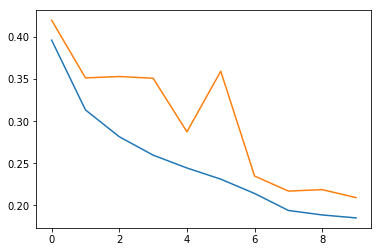

In [31]:
def lrate_schedule_fn(epoch):
    if epoch < 6:
        #print('lr: 1e-4')
#         return 1e-4
        return 1e-3
    elif epoch < 10:
        #print('lr: 5e-5')
        return 1e-4
    else:
        # print('lr: 1e-6')
        return 1e-6


lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)

history = model.fit(
     x=x_train,
     y=y_train[:, np.newaxis,:],
    # x=dataset.trainingDataset["mel"]["input"],
    # y=dataset.trainingDataset["mel"]["output"][:, np.newaxis,:],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        x_val,
        y_val[:, np.newaxis,:],
        # dataset.validationDataset["mel"]["input"],
        # dataset.validationDataset["mel"]["output"][:, np.newaxis,:]
    ),
    callbacks=[lrate_scheduler],
    verbose=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
# savedir='GLU_max_cos_0.5'
# # savedir='baseline_GLU_MIL_max'
# savedir_long='thomas_models_expes_losses/%s'%savedir

In [ ]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
# plt.yticks(fontsize=12)
# plt.xticks(fontsize=12)
# plt.legend(fontsize=12)
# plt.savefig('%s/model1_loss.png'%(savedir_long))

In [ ]:
# model.save('%s/model1.h5'%(savedir_long))

## load a trained MIL model and make strong predictions

### load MIL model

In [ ]:
# model = load_model('thomas_models/epochs5_init_MIL_max_21nov2018.h5', custom_objects={'MIL_loss': MIL_loss, 'f1': Metrics.f1, 'recall': Metrics.recall, 
#                                             'precision': Metrics.precision})

# model.summary()

In [ ]:
# plot_model(model, show_shapes=True, to_file='model_mil.png')

In [ ]:
# savedir='five_models_max_cos_0.1/9'
# savedir_long='thomas_GLU_models_alpha/%s'%savedir

### make strong predictions

on the test subset


((279, 431, 10), 'Y-6-rh8kbZf0_40.000_50.000.wav.npy')

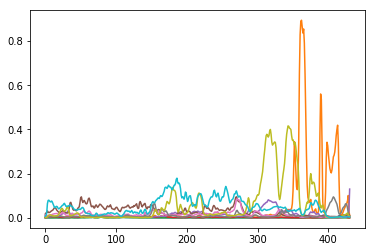

In [32]:
print('on the test subset')

# _, all_test_strong_probs = model.predict(featTest)

all_test_strong_probs = model.predict(featTest)
plt.plot(all_test_strong_probs[1])
all_test_strong_probs.shape, featTestList[1]

## load coarse-level predictions

In [34]:
# useGT=True

# if useGT:
#     all_test_preds = 
dico_coarse_predictions = load_obj("test_predictions/test_coarse_predictions.pkl")

# featTestList = dico_coarse_predictions['featTestList']
all_test_probs = dico_coarse_predictions['all_test_probs']
all_test_preds = dico_coarse_predictions['all_test_preds']
len(featTestList), all_test_probs.shape, all_test_preds.shape

In [ ]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score

# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match the corresponding 
# set of labels in y_true.

# Hamming loss is more forgiving in that it penalizes the individual labels.

print('%.2f%% %.2f%%'%(accuracy_score(y_test, all_test_preds)*100, hamming_loss(y_test, all_test_preds)*100))

print('%.2f%% %.2f%%'%(f1_score(y_test, all_test_preds, average='micro')*100, f1_score(y_test, all_test_preds, average='macro')*100))

In [ ]:
all_test_preds[:5], y_test[:5]

In [ ]:
f1_score(y_test, all_test_preds, average=None)*100

In [ ]:
precision_score(y_test, all_test_preds, average=None)  

In [ ]:
recall_score(y_test, all_test_preds, average=None)  

In [ ]:
dataset.class_correspondance

## get predictions for the predicted classes

In [ ]:
print('on the test subset')
dico_prob_curves_for_predicted_classes = get_prob_curves_for_predicted_classes(all_test_preds, 
                                                                           all_test_strong_probs, 
                                                                           featTestList, 
                                                                           DCASE2018.class_correspondance_reverse)

In [35]:
print('AT oracle: on the test subset with GT weak labels !!')
dico_prob_curves_for_predicted_classes = get_prob_curves_for_predicted_classes(y_test, 
                                                                           all_test_strong_probs, 
                                                                           featTestList, 
                                                                           DCASE2018.class_correspondance_reverse)

on the test subset with GT weak labels !!


In [ ]:
# ### save numpy strong probs array
# np.savez_compressed("%s/all_test_strong_probs.npz"%savedir_long, all_test_strong_probs=all_test_strong_probs)
# ### save prob curves
# import pickle as pkl
# pickle.dump( dico_prob_curves_for_predicted_classes, open( "%s/dico_prob_curves_for_predicted_classes.pkl"%savedir_long, "wb" ) )

In [ ]:
# print('on the eval subset')
# dico_prob_curves_for_predicted_classes = get_prob_curves_for_predicted_classes(all_eval_preds, 
#                                                                            all_eval_strong_probs, 
#                                                                            featEvalList, 
#                                                                            DCASE2018.class_correspondance_reverse)


# Score

In [38]:
def smoothMeanAvg(temporalPrediction: np.array, **kwargs):
    
    print("Smooting using the smooth moving average algorithm")
    
    def smooth(data, window_len = 11):
        # retreiving extract arguments
        keys = kwargs.keys()
        window_len = kwargs["window_len"] if "window_len" in keys else 11
        weight = kwargs["weight"] if "weight" in keys else 2

        window_len = int(window_len)

        if window_len < 3:
            return data

        s = np.r_[weight * data[0] - data[window_len - 1::-1], data, weight * data[-1] - data[-1:-window_len:-1]]
        w = np.ones(window_len, 'd')
        y = np.convolve(w / w.sum(), s, mode='same')
        return y[window_len:-window_len + 1]

    outputs = []
    for clipInd in range(len(temporalPrediction)):
        clip = temporalPrediction[clipInd]
        curves = []
        for clsInd in range(len(clip.T)):
            #clip.T[clsInd] = smooth(clip.T[clsInd])
            curves.append(smooth(clip.T[clsInd]))
        curves = np.array(curves)
        outputs.append(curves.T)
    outputs = np.array(outputs)
    return outputs

In [39]:
# print(testListFile[:5])
print(featTestList[:5])
print(list(dico_prob_curves_for_predicted_classes.keys())[:5])
nbFrame = 431

# rearange list of results
results = []
for f in featTestList:
# for f in testListFile:
    f = f.replace('.wav.npy', '')
    info = dico_prob_curves_for_predicted_classes[f]
    
    curves = np.array([[0]*dataset.nbClass for _ in range(nbFrame)], dtype=np.float32)
    
    for cls in info:
        index = DCASE2018.class_correspondance[cls]
        curves[:,index] = info[cls]
        
    results.append(curves)

results = np.array(results)
results.shape

['Y0UN02RkbG_U_7.000_17.000.wav.npy', 'Y-6-rh8kbZf0_40.000_50.000.wav.npy', 'Y6ocUrRBIuls_340.000_350.000.wav.npy', 'Y7wPIQMsalK8_70.000_80.000.wav.npy', 'Y-dDpGRPHzM0_30.000_40.000.wav.npy']
['Y4WLQloq6iLs_190.000_200.000', 'Y0plDocPM9Ig_80.000_90.000', 'Y1asrcrzsvuo_160.000_170.000', 'Y1tFkjBMoUkM_90.000_100.000', 'Y8fDeRi8Lqyg_40.000_50.000']


(279, 431, 10)

In [42]:
encoder = Encoder()

temporalPrediction = smoothMeanAvg(results, window_len=19)

segments = encoder.encode(results, method="hysteresis", high=0.03, low=0.03, smooth="smoothMovingAvg", window_len=19)  # 21.50 %
# segments = encoder.encode(results, method="hysteresis", high=0.07, low=0.07, smooth="smoothMovingAvg", window_len=19)  # 21.50 %
# segments = encoder.encode(results, method="hysteresis", high=0.05, low=0.2, smooth="smoothMovingAvg", window_len=19)  # 21.50 %
# segments = encoder.encode(results, method="hysteresis", high=0.07, low=0.2, smooth="smoothMovingAvg", window_len=19)  # 21.50 %

toEvaluate = encoder.parse(segments, dataset.testFileList)

print("perform evaluation ...")             
with open("test_predictions/toEvaluate.csv", "w") as f:                    
    f.write("filename\tonset\toffset\tevent_label\n") 
    f.write(toEvaluate)   

perso_event_list = MetaDataContainer() 
perso_event_list.load(filename="test_predictions/toEvaluate.csv")

ref_event_list = MetaDataContainer()   
ref_event_list.load(filename=dataset.meta_test)

event_based_metric = event_based_evaluation(ref_event_list, perso_event_list)
print(event_based_metric)


Smooting using the smooth moving average algorithm
Smooting using the smooth moving average algorithm
perform evaluation ...
Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 34.85 %
    Precision                       : 33.13 %
    Recall                          : 36.75 %
  Error rate
    Error rate (ER)                 : 1.36 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.62 
    Insertion rate                  : 0.73 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 35.00 %
    Precision                       : 31.92 %
    Recall                          : 41.

In [ ]:
event_list = ['Frying', 'Speech', 'Alarm_bell_ringing', 'Vacuum_cleaner', 'Dog', 'Dishes', 'Running_water', 'Electric_shaver_toothbrush', 'Cat', 'Blender']

for e in event_list:
    print(e, event_based_metric.results_class_wise_metrics()[e]['f_measure'])

In [ ]:
dataset.testFileList[4], segments[4]

In [ ]:
dataset.testFileList[49], segments[49]

In [ ]:
temporalPrediction.shape

In [ ]:
np.linspace(0, 10, num=10)

In [ ]:
def encodeUsingHysteresis(temporalPrediction: np.array, **kwargs):
    """ Hysteresys based localization of the sound event in the clip using the temporal prediction.

    :param temporalPrediction: A 3-dimension numpy array (<nb clip>, <nb frame>, <nb class>)
    :param low: low thresholds
    :param high: high thresholds
    :return: the result of the system under the form of a strong annotation text where each line represent on timed event
    """
    low = kwargs["low"] if "low" in kwargs.keys() else 0.4
    high = kwargs["high"] if "high" in kwargs.keys() else 0.6
    prediction = temporalPrediction

    output = []

    for clip in prediction:
        labeled = dict()

        cls = 0
        for predictionPerClass in clip.T:
            converted = list()
            segment = [0, 0]
            nbSegment = 1
            for i in range(len(predictionPerClass)):
                element = predictionPerClass[i]

                # first element
                if i == 0:
                    segment = [1.0, 1] if element > high else [0.0, 1]

                # then
                if element > high:
                    if segment[0] == 1:
                        segment[1] += 1
                    else:
                        converted.append(segment)
                        nbSegment += 1
                        segment = [1.0, 1]
                elif low <= element:
                    segment[1] += 1
                else:
                    if segment[0] == 0:
                        segment[1] += 1
                    else:
                        converted.append(segment)
                        nbSegment += 1
                        segment = [0.0, 0]
                
#             if nbSegment == 1:
            converted.append(segment)

            labeled[cls] = copy.copy(converted)
            cls += 1

        output.append(labeled)

    return output


In [ ]:
segments2 = encodeUsingHysteresis(temporalPrediction, low=0.05, high=0.2)

In [ ]:
segments2[49]

In [ ]:
toEvaluate = encoder.parse(segments2, dataset.testFileList)

print("perform evaluation ...")             
with open("test_predictions/toEvaluate.csv", "w") as f:                    
    f.write("filename\tonset\toffset\tevent_label\n") 
    f.write(toEvaluate)   

perso_event_list = MetaDataContainer() 
perso_event_list.load(filename="test_predictions/toEvaluate.csv")

ref_event_list = MetaDataContainer()   
ref_event_list.load(filename=dataset.meta_test)

event_based_metric = event_based_evaluation(ref_event_list, perso_event_list)
print(event_based_metric)


In [ ]:
dummy_vec = np.random.rand(1,64)
dummy_score = np.dot(dummy_vec, w[0]) + w[1] 
dummy_score[0,5]-dummy_score[0,6]


# Score plot examples

In [36]:
indice = 4
nplots = 2

# indice = 7
# indice = 23
# indice = 49
# nplots = 3

featTestList.index('Y5J603SAj7QM_210.000_220.000.wav.npy')

# indice = featTestList.index('Y-dDpGRPHzM0_30.000_40.000.wav.npy')

# _, prob = model.predict(featTest[indice][np.newaxis])
prob = model.predict(featTest[indice][np.newaxis])

# prob = dico_prob_curves_for_predicted_classes['Y-dDpGRPHzM0_30.000_40.000']
fichier_id=featTestList[indice].replace('.wav.npy', '')
print(fichier_id, prob.shape, prob[0,:,1].shape, np.mean(prob[0], axis=0))

Y-dDpGRPHzM0_30.000_40.000 (1, 431, 10) (431,) [0.00559192 0.24131942 0.02227061 0.00277229 0.00129201 0.00951379
 0.00200179 0.00572958 0.00137073 0.0030799 ]


Speech 0.9834706
1.0
Dog 0.88987577
1.0


/home/thomas/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


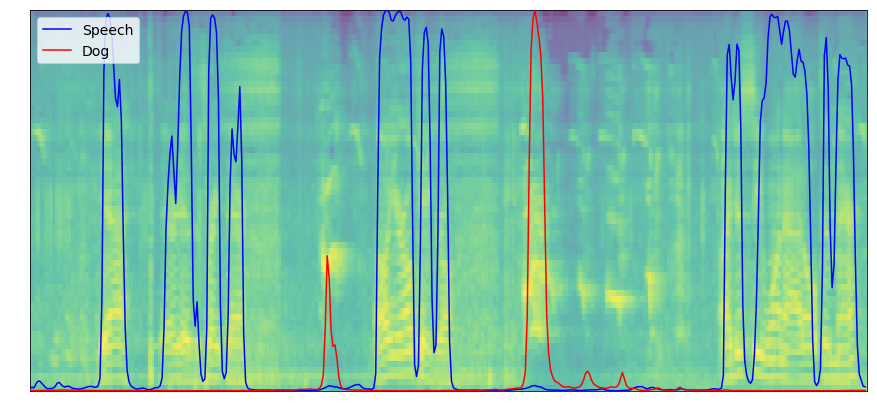

In [37]:
smoothed=False

# temporalPrediction = smoothMeanAvg(results, window_len=19)

time_vector = np.linspace(0, 10, prob.shape[1])

fig, axs = plt.subplots(1,1,figsize=(15,7))

### axs.imshow(featTest[indice][:,:,0] , cmap='gray', interpolation='none', alpha=0.3)
axs.imshow(featTest[indice][:,:,0], origin='lower', interpolation='none', aspect='auto', alpha=0.7)

# enlever les ticks

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off


# # indice = 4
dico={0: 1, 1: 2}
dico_c={0: 'b', 1: 'r'}
dico_l={0: 'Speech', 1: 'Dog'}

# # indice = 15
# dico={0: 0, 1: 1}
# dico_c={0: 'b', 1: 'r'}
# dico_l={0: 'Alarm', 1: 'Speech'}

# classes = ['Speech', 'Dishes', 'Frying']
# dico={}
# dico_c={0: 'b', 1: 'r', 2: 'y'}
# dico_l={}
# for i,c in enumerate(classes):
#     n = DCASE2018.class_correspondance[c]
#     dico[i] = n
#     dico_l[i] = c

# dico={0: 3}
# dico_c={0: 'b'}
# dico_l={0: 'Cat'}

fig.canvas.draw()

box = axs._position.bounds
height = box[3] / nplots

for i in range(nplots):

    tmpax = fig.add_axes([box[0], box[1], box[2], box[3]])
    tmpax.set_axis_off()
    
    
    if smoothed:
        proba= temporalPrediction[indice,:,dico[i]]
    else:
        proba = prob[0,:,dico[i]]

    print(dico_l[i], np.max(proba))
###     proba = dico_toto['Y-dDpGRPHzM0_30.000_40.000'][i]
    proba = (proba - np.min(proba)) / (np.max(proba) - np.min(proba))
    print(np.max(proba))
    
#     concat = np.concatenate((time_vector[:,np.newaxis], proba[:,np.newaxis]), axis=-1)
#     np.savetxt('/home/thomas/research/demos/demo_dcase2018/{}_Y5J603SAj7QM_210.000_220.000.txt'.format(dico_l[i]), concat, fmt='%.3f')
    
    tmpax.plot(proba, dico_c[i], label=dico_l[i])
    tmpax.set_ylim(0, np.max(proba))
    tmpax.set_xlim(0, 431)
    plt.legend(loc=2, fontsize=14)

# if smoothed:
#     plt.savefig('%s/%s_smoothed.png'%(savedir_long, fichier_id))
#     np.savez('%s/%s_probs_smoothed.npz'%(savedir_long, fichier_id), prob=temporalPrediction[indice])    
# else:
#     plt.savefig('%s/%s.png'%(savedir_long, fichier_id))
#     np.savez('%s/%s_probs.npz'%(savedir_long, fichier_id), prob=prob[0,:,:])
    


Speech 0.5556795
1.0
Dishes 0.5220107
1.0
Frying 0.7970455
1.0
corr(dishes, frying) = 98.552%
corr(dishes, speech) = -19.978%
corr(speech, frying) = -19.972%


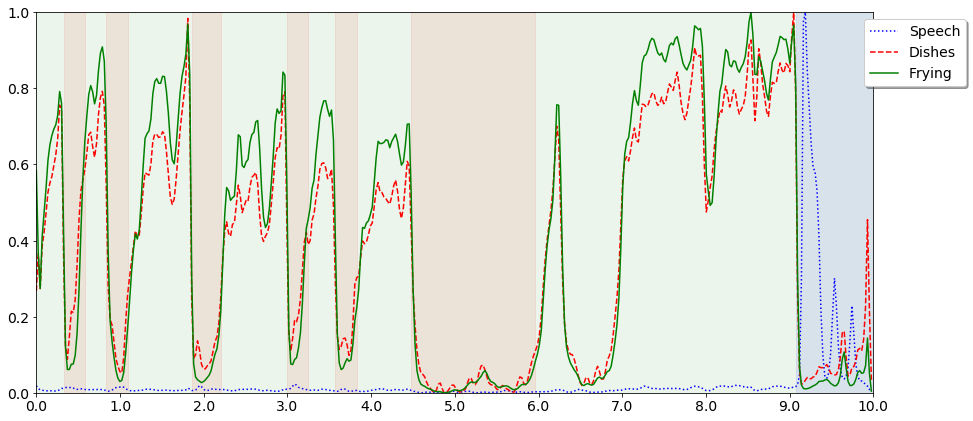

In [43]:
from matplotlib.patches import Rectangle

indice = 49
fichier_id=featTestList[indice].replace('.wav.npy', '')

smoothed=False
withLegend=True

if smoothed:
    prob= temporalPrediction[indice]
else:
    prob = model.predict(featTest[indice][np.newaxis])


xticks_labels = 0.5*np.array(range(0, 21, 2))
xticks_ind = xticks_labels * 431 / 10
xticks_labels = xticks_labels.tolist()
xticks_ind = xticks_ind.tolist()

fig, axs = plt.subplots(1,1,figsize=(15,7))

### axs.imshow(featTest[indice][:,:,0] , cmap='gray', interpolation='none', alpha=0.3)
# axs.imshow(featTest[indice][:,:,0], origin='lower', interpolation='none', aspect='auto', alpha=0.5)

# enlever les ticks

# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left=False,      # ticks along the bottom edge are off
#     right=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False) # labels along the bottom edge are off


# # indice = 4
# nplots = 2
# dico={0: 1, 1: 2}
# dico_c={0: 'b', 1: 'r'}
# dico_l={0: 'Speech', 1: 'Dog'}

# # # indice = 7
# nplots = 2
# dico={0: 0, 1: 1}
# dico_c={0: 'b', 1: 'r'}
# dico_l={0: 'Alarm', 1: 'Speech'}

# indice = 15
nplots = 3
classes = ['Speech', 'Dishes', 'Frying']

dico_gt = {'Speech': [[391, 431]], 'Dishes': [[14, 25], [36, 47], [80, 95], [129, 140], [154, 165], [193, 257]], 'Frying': [[0, 431]]}

dico={}
dico_c={0: 'b:', 1: 'r--', 2: 'g'}
dico_c2={0: 'b', 1: 'r', 2: 'g'}
dico_l={}
for i,c in enumerate(classes):
    n = DCASE2018.class_correspondance[c]
    dico[i] = n
    dico_l[i] = c
dico_probas = {}

# dico={0: 3}
# dico_c={0: 'b'}
# dico_l={0: 'Cat'}

fig.canvas.draw()

box = axs._position.bounds
height = box[3] / nplots

for i in range(nplots):

    if smoothed:
        proba= temporalPrediction[indice,:,dico[i]]
    else:
        proba = prob[0,:,dico[i]]
    
    dico_probas[classes[i]] = proba
    
    print(dico_l[i], np.max(proba))
###     proba = dico_toto['Y-dDpGRPHzM0_30.000_40.000'][i]
#     proba = (proba - np.min(proba[10:])) / (np.max(proba[10:]) - np.min(proba[10:]))
    proba = (proba - np.min(proba)) / (np.max(proba) - np.min(proba))
    print(np.max(proba))
    
    plt.plot(proba, dico_c[i], label=dico_l[i])
    plt.ylim(0, np.max(proba))
    plt.xlim(0, 431)
    
    if classes[i] in dico_gt:
        for el in dico_gt[classes[i]]:
            rect = Rectangle((el[0],0), width=(el[1]-el[0]), height=1.072414, alpha=0.08, color=dico_c2[i])
            axs.add_patch(rect)
    
###     plt.legend(loc='best', fontsize=14)
if withLegend:
    plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(1.05, 1),  shadow=True, ncol=1)

plt.xticks(xticks_ind, xticks_labels, fontsize=14)
plt.yticks(fontsize=14)

# bbox_to_anchor=(0.5, -0.05)
# print(dico_probas['Dishes'].shape, np.corrcoef(dico_probas['Dishes'], dico_probas['Frying']))
print('corr(dishes, frying) = %.3f%%'% (100*np.corrcoef(dico_probas['Dishes'], dico_probas['Frying'])[0,1]))
print('corr(dishes, speech) = %.3f%%'% (100*np.corrcoef(dico_probas['Dishes'], dico_probas['Speech'])[0,1]))
print('corr(speech, frying) = %.3f%%'% (100*np.corrcoef(dico_probas['Speech'], dico_probas['Frying'])[0,1]))

# if smoothed:
#     if withLegend:
#         plt.savefig('%s/%s_smoothed_no_spectro_with_legend.png'%(savedir_long, fichier_id))
#     else:
#         plt.savefig('%s/%s_smoothed_no_spectro.png'%(savedir_long, fichier_id))
#     np.savez('%s/%s_probs_smoothed.npz'%(savedir_long, fichier_id), prob=temporalPrediction[indice])    
# else:
#     if withLegend:
#         plt.savefig('%s/%s_no_spectro_with_legend.png'%(savedir_long, fichier_id))
#     else:
#         plt.savefig('%s/%s_no_spectro.png'%(savedir_long, fichier_id))
#     np.savez('%s/%s_probs.npz'%(savedir_long, fichier_id), prob=prob[0,:,:])
    


## covariance

In [ ]:
def rescale_3d_array(array_3d):
    """rescale between 0 and 1 a 1d-array"""
    return (array_3d - np.min(array_3d[:,3:-3,:], axis=1, keepdims=True)) / (np.max(array_3d[:,3:-3,:], axis=1, keepdims=True) - np.min(array_3d[:,3:-3,:], axis=1, keepdims=True))


In [ ]:
def compute_global_off_diagonal_corr_value(corr_mat):
    tmp = np.copy(corr_mat)
    tmp[range(10), range(10)] = 0
    tmp[tmp<0] = 0 # don't count negative correlations
    nb_pairs_to_consider = sum(range(1,10))
#     tmp=np.abs(tmp) # count all correlations as positive...
#     nb_pairs_to_consider = sum(range(1,11))
    return 0.5*np.sum(tmp)/nb_pairs_to_consider


In [ ]:
means_over_time = np.mean(all_test_strong_probs, axis=1)

# cov = np.cov(means_over_time.T)
corr = np.corrcoef(means_over_time.T)

all_test_strong_probs.shape, means_over_time.shape, corr.shape

In [ ]:
# labels = [DCASE2018.class_correspondance_reverse[i] for i in range(10)]
labels = ['Alarm bell ringing',
 'Speech',
 'Dog',
 'Cat',
 'Vacuum cleaner',
 'Dishes',
 'Frying',
 'Electric shaver toothbrush',
 'Blender',
 'Running water']

plt.figure(figsize=(7,7))
plt.imshow(corr)
plt.xticks(range(10), labels, rotation=80, fontsize=12) # 'vertical'
plt.yticks(range(10), labels, fontsize=12)
plt.colorbar()
plt.tight_layout()

# plt.savefig('%s/corr.png'%(savedir_long))
# np.savez('%s/corr.npz'%(savedir_long), corr)


# Alarm_bell_ringing 0
# Speech 1
# Dog 2
# Cat 3
# Vacuum_cleaner 4
# Dishes 5
# Frying 6
# Electric_shaver_toothbrush 7
# Blender 8
# Running_water 9

In [ ]:
global_corr = compute_global_off_diagonal_corr_value(corr)
print('%.2f%%'%(global_corr*100.))

In [ ]:
means_over_time = np.mean(temporalPrediction, axis=1)

# cov = np.cov(means_over_time.T)
smoothed_corr = np.corrcoef(means_over_time.T)
temporalPrediction.shape

In [ ]:
# import scipy.stats
# scipy.stats.pearsonr(inputa[i], inputb[i])[0]**2

In [ ]:
labels = ['Alarm bell ringing',
 'Speech',
 'Dog',
 'Cat',
 'Vacuum cleaner',
 'Dishes',
 'Frying',
 'Electric shaver toothbrush',
 'Blender',
 'Running water']

plt.figure(figsize=(7,7))
plt.imshow(smoothed_corr)
plt.xticks(range(10), labels, rotation=80, fontsize=12) # 'vertical'
plt.yticks(range(10), labels, fontsize=12)
plt.colorbar()
plt.tight_layout()

# plt.savefig('%s/corr_smoothed_probs.png'%(savedir_long))
# np.savez('%s/corr_smoothed_probs.npz'%(savedir_long), corr)



In [ ]:
global_corr = compute_global_off_diagonal_corr_value(smoothed_corr)
print('%.2f%%'%(global_corr*100.))

In [ ]:
tmp = np.copy(rescaled_corr)
toto = range(10)
tmp[toto, toto] = 0
np.diag(np.dot(tmp, tmp.T))*100

In [ ]:
toto=3
p6=rescaled_all_test_strong_probs[toto, :,6]
p9=rescaled_all_test_strong_probs[toto, :,5]
plt.figure(figsize=(7,5))
plt.plot(p6)
plt.plot(p9)

In [ ]:
corr_wo = np.load('thomas_models_expes_losses/baseline_MIL_max/corr_smoothed_probs.npz')
corr_wo = corr_wo['arr_0']

corr_w = np.load('thomas_models_expes_losses/max_cos_1e0_2/corr_smoothed_probs.npz')
corr_w = corr_w['arr_0']

corr_wo[5,6], corr_w[5,6]

## event overlap analysis

In [ ]:
def csv2dico(csvpath):
    with open(csvpath, 'r') as fh:
        firstLine=True
        dico = {}
        for ligne in fh:
            if firstLine: 
                firstLine=False
                continue
            tab = ligne.rstrip().split('\t')
            nom, onset, offset, c = tab
            onset, offset = float(onset), float(offset)
            if nom in dico:
                if c in dico[nom]:
                    dico[nom][c].append([onset, offset])
                else:
                    dico[nom][c]=[[onset, offset]]
            else:
                dico[nom] = {c: [[onset, offset]]}
            # print(nom, c, onset, offset)
    return dico


In [ ]:
def compute_overlap(d1, f1, d2, f2):
    return max(0., (min(f1, f2) - max(d1, d2))*((d2<=d1)*1*(f2>d1)+(d2>d1)*1*(f1>d2)))


def unit_test_compute_overlap():
    d1, f1, d2, f2 = [0., 10., 2., 4.]
    print(compute_overlap(d1, f1, d2, f2))
    d1, f1, d2, f2 = [8., 10., 2., 4.]
    print(compute_overlap(d1, f1, d2, f2))
    d1, f1, d2, f2 = [8., 10., 2., 9.]
    print(compute_overlap(d1, f1, d2, f2))
    d1, f1, d2, f2 = [8., 10., 9., 9.5]
    print(compute_overlap(d1, f1, d2, f2))
    
unit_test_compute_overlap()

In [ ]:
def compute_all_overlaps(dico):
    
    total_overlap = 0.
    
    for fid in dico.keys():
        fid_dico = dico[fid]
        
        event_list = list(fid_dico.keys())
        
        for i in range(len(event_list)):
            boundaries_i = fid_dico[event_list[i]]
            for b_i in boundaries_i:
                for j in range(i+1, len(event_list)):
                    boundaries_j = fid_dico[event_list[j]]
                    for b_j in boundaries_j:
                        total_overlap += compute_overlap(b_i[0], b_i[1], b_j[0], b_j[1])
    return total_overlap

dico = csv2dico('/baie/corpus/DCASE2018/task4/metadata/test.csv')
# dico['Y-6-rh8kbZf0_40.000_50.000.wav']
print('GT overlap: %.2f min'%(compute_all_overlaps(dico)/60.))

dico = csv2dico('thomas_models_expes_losses/baseline_GLU_MIL_max/toEvaluate.csv')
# dico['Y-6-rh8kbZf0_40.000_50.000.wav']
print('GLU-MIL overlap: %.2f min'%(compute_all_overlaps(dico)/60.))
# 709 s

dico = csv2dico('thomas_GLU_models_alpha/five_models_max_cos_0.1/9/toEvaluate_with_weak_predictions.csv')
# dico['Y-6-rh8kbZf0_40.000_50.000.wav']
print('GLU-MIL+cos overlap: %.2f min'%(compute_all_overlaps(dico)/60.))

dico = csv2dico('thomas_GLU_models_alpha/five_models_max_cos_0.1/9/toEvaluate_with_oracle_weak_labels.csv')
# dico['Y-6-rh8kbZf0_40.000_50.000.wav']
print('GLU-MIL+cos+oracle overlap: %.2f min'%(compute_all_overlaps(dico)/60.))

dico = csv2dico('test_predictions/toEvaluate.csv')
# dico['Y-6-rh8kbZf0_40.000_50.000.wav']
print('weight cos overlap: %.2f min'%(compute_all_overlaps(dico)/60.))

## duration distributions

In [ ]:
def compute_duration_dico(dico):
    
    duration_dico = {}
    
    for fid in dico.keys():
        fid_dico = dico[fid]
        
        event_list = list(fid_dico.keys())
        
        for ev in event_list:
            if ev not in duration_dico:
                duration_dico[ev] = [] 
            boundaries = fid_dico[ev]
            for b in boundaries:
                duration_dico[ev].append(b[1]-b[0])
    return duration_dico


In [ ]:
dico = csv2dico('/baie/corpus/DCASE2018/task4/metadata/test.csv')
duration_gt = compute_duration_dico(dico)

# dico = csv2dico('thomas_models_expes_losses/baseline_GLU_MIL_max/toEvaluate.csv')
# duration = compute_duration_dico(dico)

dico = csv2dico('thomas_GLU_models_alpha/five_models_max_cos_0.1/9/toEvaluate_with_weak_predictions.csv')
duration = compute_duration_dico(dico)

# dico = csv2dico('thomas_GLU_models_alpha/five_models_max_cos_0.1/9/toEvaluate_with_oracle_weak_labels.csv')
# duration = compute_duration_dico(dico)


In [ ]:
def plot_duration(duration_dico, duration_dico2):
    
    fig, ax = plt.subplots(2, 5, sharex=True, figsize=(15,7))

    liste = list(DCASE2018.class_correspondance.keys())
    liste.sort()
    ind=0
    for k in liste:
        v = duration_dico[k]
        v2 = duration_dico2[k]
        if ind<5:
            ax[0, ind].hist(v, bins=10, range=(0, 10), alpha=0.8) # density=True, 
            ax[0, ind].hist(v2, bins=10, range=(0, 10), histtype='step', color='k', lw=2)
            ax[0, ind].set_title(k)
            # ax[0, ind].xlim([0, 10])
        else:
            ax[1, ind-5].hist(v, bins=10, range=(0, 10), alpha=0.8)
            ax[1, ind-5].hist(v2, bins=10, range=(0, 10), histtype='step', color='k', lw=2)
            ax[1, ind-5].set_title(k)
            # ax[1, ind-5].xlim([0, 10])
        ind +=1
    # plt.hist()
    
    plt.tight_layout()
#    plt.savefig('duration_hist_GLU_MIL.png')
    plt.savefig('duration_hist_GLU_MIL_cos.png')
    plt.show()
    
plot_duration(duration_gt, duration)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.DataFrame.from_dict(duration,orient='index')
df = df.unstack().dropna().sort_index(level=1)

df.columns = ['Cat', 'Alarm_bell_ringing', 'Dog', 'Dishes', 'Electric_shaver_toothbrush', 'Running_water', 
              'Speech', 'Vacuum_cleaner', 'Frying', 'Blender']

In [ ]:
df.shape, df.columns

In [ ]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(df)

for col_id in df.columns:
    sns.distplot(df[col_id])

## Weight distributions

In [ ]:
layer = model.layers[-1]

w = layer.get_weights()

w[0].shape, w[1].shape

In [ ]:
for k,v in DCASE2018.class_correspondance.items():
    print(k,v)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances as sklearn_euclidean_distances
plt.figure(figsize=(10,7))
# w[0][:,5].sort()
# w[0][:,6].sort()
plt.plot(w[0][:,5])
plt.plot(w[0][:,6])
plt.show()

for i in range(10):
    print(i, sklearn_euclidean_distances(w[0][:,6].reshape(1, -1), w[0][:,i].reshape(1, -1))[0,0])

In [ ]:
w[1][5], w[1][6]

# Baseline False strong labeling

In [ ]:

melInput = Input(dataset.getInputShape("mel"))

# ---- mel convolution part ----
mBlock1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(melInput)
mBlock1 = BatchNormalization()(mBlock1)
mBlock1 = Activation(activation="relu")(mBlock1)
mBlock1 = MaxPooling2D(pool_size=(4, 1))(mBlock1)
mBlock1 = Dropout(0.1)(mBlock1)
# mBlock1 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock1)

mBlock2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock1)
mBlock2 = BatchNormalization()(mBlock2)
mBlock2 = Activation(activation="relu")(mBlock2)
mBlock2 = MaxPooling2D(pool_size=(4, 1))(mBlock2)
# mBlock2 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock2)
mBlock2 = Dropout(0.1)(mBlock2)
    
mBlock3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(mBlock2)
mBlock3 = BatchNormalization()(mBlock3)
mBlock3 = Activation(activation="relu")(mBlock3)
mBlock3 = MaxPooling2D(pool_size=(4, 1))(mBlock3)
# mBlock3 = SpatialDropout2D(0.3, data_format=K.image_data_format())(mBlock3)
mBlock3 = Dropout(0.1)(mBlock3)
    
targetShape = int(mBlock3.shape[1] * mBlock3.shape[2])
mReshape = Reshape(target_shape=(targetShape, 64))(mBlock3)

gru = Bidirectional(
    GRU(kernel_initializer='glorot_uniform', activation='tanh', recurrent_dropout=0.1, \
        dropout=0.1, units=64, return_sequences=True)
)(mReshape)

gru = Dropout(0.1)(gru)

output = TimeDistributed(
    Dense(64, activation="relu"),
)(gru)

output = Dropout(0.1)(output)

output = TimeDistributed(
    Dense(dataset.nbClass, activation="sigmoid"),
)(output)

# output = TimeDistributed(
#  Lambda(lambda x: (x - K.min(x, axis=1, keepdims=True))/(K.max(x, axis=1, keepdims=True)- K.min(x, axis=1, keepdims=True)) ),
# )(output)

### output = GlobalAveragePooling1D()(output)

model = Model(inputs=[melInput], outputs=output)

# compile model
# metrics = ["accuracy"]
optimizer = optimizers.Adam()

metrics = ["accuracy", Metrics.f1, Metrics.recall, Metrics.precision]
loss = "binary_crossentropy"

optimizer = optimizers.Adam()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary(line_length=100)

In [ ]:
epochs = 100
batch_size = 32

def lrate_schedule_fn(epoch):
    if epoch < 20:
        #print('lr: 1e-4')
#         return 1e-4
        return 1e-3
    elif epoch < 50:
        #print('lr: 5e-5')
        return 1e-4
    else:
        # print('lr: 1e-6')
        return 1e-6


lrate_scheduler = keras.callbacks.LearningRateScheduler(lrate_schedule_fn)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=15, verbose=1)

history = model.fit(
     x=x_train,
     y=np.tile(y_train[:, np.newaxis,:], (1, 431, 1)),
    # x=dataset.trainingDataset["mel"]["input"],
    # y=dataset.trainingDataset["mel"]["output"][:, np.newaxis,:],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(
        x_val,
        np.tile(y_val[:, np.newaxis,:], (1, 431, 1)),
        # dataset.validationDataset["mel"]["input"],
        # dataset.validationDataset["mel"]["output"][:, np.newaxis,:]
    ),
    callbacks=[lrate_scheduler, early_stop],
    verbose=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])



In [ ]:
savedir='false_strong_labels'
# savedir='baseline_MIL_max'
savedir_long='thomas_models_expes_losses/%s'%savedir

In [ ]:
model.save('%s/model1.h5'%(savedir_long))

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig('%s/model1_loss.png'%(savedir_long))